In [1]:
import pandas as pd
import numpy as np
import pickle
import operator
import copy

from scipy.stats import boxcox

from dateutil.parser import parse
from datetime import datetime

import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn import metrics

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import cross_val_score

In [2]:
with open('books_cleaned.pkl', 'rb') as picklefile:
    books = pickle.load(picklefile)

In [4]:
books.a_avg_rating.describe()

count    742.000000
mean       3.976900
std        0.163559
min        3.210000
25%        3.870000
50%        3.970000
75%        4.060000
max        4.490000
Name: a_avg_rating, dtype: float64

In [5]:
books.drop(['a_id', 'b_id', 'b_ratings_count', 'pub_yr'], axis=1, inplace=True)

Create dummy variables

In [6]:
dummy_columns = ['hometown', 'gender', 'decade', 'b_wks_on_list', 'a_wks_on_list', 'a_books_on_list']
dummies = books[dummy_columns]
books.drop(['hometown', 'gender', 'decade'], axis=1, inplace=True)

In [7]:
#hometown in NY
dummies.loc[dummies['hometown'].str.contains('New York'), 'a_ny_hometown'] = 1
dummies['a_ny_hometown'].fillna(0, inplace=True)

/Users/evaward/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/evaward/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/evaward/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.

In [8]:
gender_dummies = pd.get_dummies(dummies['gender'], prefix='a', drop_first=True)
dummies = dummies.merge(gender_dummies, left_index=True, right_index=True)

In [9]:
decade_dummies = pd.get_dummies(dummies['decade'], prefix='b', drop_first=True)
dummies = dummies.merge(decade_dummies, left_index=True, right_index=True)

In [10]:
dummies.loc[dummies['b_wks_on_list'] > 1, 'b_repeat'] = 1
dummies['b_repeat'].fillna(0, inplace=True)

In [11]:
dummies.loc[dummies['a_wks_on_list'] > 1, 'a_repeat'] = 1
dummies['a_repeat'].fillna(0, inplace=True)

In [12]:
dummies.drop(dummy_columns, axis=1, inplace=True)

Keep only numerical features

In [13]:
num_columns = []
for column in books.columns:
    if np.dtype(books[column]) == 'float64' or np.dtype(books[column]) == 'int64':
        num_columns.append(column)
books = books[num_columns]

Use boxcox on skewed features

In [14]:
bc = pd.DataFrame()

In [15]:
bc_columns = ['b_count', 'b_rating_5_count', 'b_rating_4_count', 'b_rating_3_count', \
              'a_works_count', 'a_ratings_count', 'a_text_reviews_count', 'b_wks_on_list', \
              'a_wks_on_list', 'a_books_on_list']

In [16]:
bc['b_count_bx'] = boxcox(books['b_count'])[0]
bc['b_rating_5_count_bx'] = boxcox(books['b_rating_5_count'])[0]
bc['b_rating_4_count_bx'] = boxcox(books['b_rating_4_count'])[0]
bc['b_rating_3_count_bx'] = boxcox(books['b_rating_3_count'])[0]
bc['a_works_count_bx'] = boxcox(books['a_works_count'])[0]
bc['a_ratings_count_bx'] = boxcox(books['a_ratings_count'])[0]
bc['a_text_reviews_count_bx'] = boxcox(books['a_text_reviews_count'])[0]
bc['b_wks_on_list_bx'] = boxcox(books['b_wks_on_list'])[0]
bc['a_wks_on_list_bx'] = boxcox(books['a_wks_on_list'])[0]
bc['a_books_on_list_bx'] = boxcox(books['a_books_on_list'])[0]

In [17]:
#Error: 'ValueError: Data must be positive.'
#bc['b_txt_rev_count_bx'] = boxcox(books['b_txt_rev_count'])[0]
#bc['b_rating_2_count_bx'] = boxcox(books['b_rating_2_count'])[0]
#bc['b_rating_1_count_bx'] = boxcox(books['b_rating_1_count'])[0]
#bc['a_fans_count_bx'] = boxcox(books['a_fans_count'])[0]

Add boxcox features back to books df

In [18]:
books = books.join(bc)

Standardize numerical features (not dummies)

In [19]:
columns = books.columns
books = pd.DataFrame(preprocessing.scale(books))
books.columns = columns

Add categorical features back to books df

In [20]:
books = books.join(dummies)

In [21]:
books.drop(bc_columns, axis=1, inplace=True)

In [49]:
books = books.drop(['b_rating_5_count_bx', 'b_rating_4_count_bx', 'b_rating_3_count_bx', 'b_rating_2_count', 'b_rating_1_count'], axis=1)

In [50]:
books.to_pickle('books_for_modeling.pkl')

In [51]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 23 columns):
b_avg_rating               742 non-null float64
b_txt_rev_count            742 non-null float64
a_fans_count               742 non-null float64
a_avg_rating               742 non-null float64
b_count_bx                 742 non-null float64
a_works_count_bx           742 non-null float64
a_ratings_count_bx         742 non-null float64
a_text_reviews_count_bx    742 non-null float64
b_wks_on_list_bx           742 non-null float64
a_wks_on_list_bx           742 non-null float64
a_books_on_list_bx         742 non-null float64
a_ny_hometown              742 non-null float64
a_male                     742 non-null float64
a_not reported             742 non-null float64
b_1950s                    742 non-null float64
b_1960s                    742 non-null float64
b_1970s                    742 non-null float64
b_1980s                    742 non-null float64
b_1990s                    742 

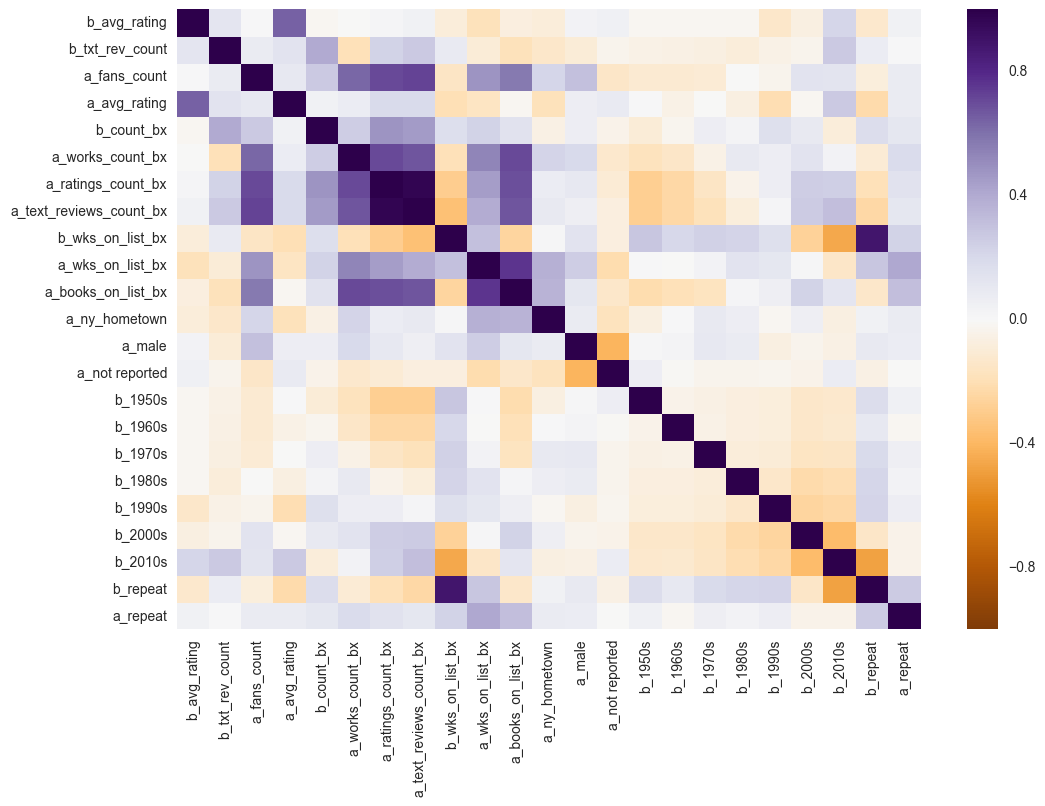

In [55]:
fig, ax = plt.subplots(figsize=(12,8))
#cmap = sns.diverging_palette(164, 50, sep=20, as_cmap=True)
sns.heatmap(books.corr(), ax=ax, cmap="PuOr");

### _Model 1: All features_

In [56]:
model1 = books
y = model1.pop('b_avg_rating')

In [57]:
lsm = sm.OLS(y,model1)
fit = lsm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           b_avg_rating   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     29.12
Date:                Sun, 05 Feb 2017   Prob (F-statistic):           2.04e-84
Time:                        18:41:40   Log-Likelihood:                -816.74
No. Observations:                 742   AIC:                             1677.
Df Residuals:                     720   BIC:                             1779.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
b_txt_rev_count             0.1054      0.041      2.543      0.011         0.024     0.187
a_fans_count                0.0128      0.049      0.260      0.795        -0.084     0.109
a_avg_rating                0.6502      0.031     20.835      0.000         0.589     0.711
b_count_bx                  0.0026      0.038      0.070      0.944        -0.071     0.077
a_works_count_bx            0.1227      0.049      2.492      0.013         0.026     0.219
a_ratings_count_bx         -0.3752      0.153     -2.450      0.015        -0.676    -0.075
a_text_reviews_count_bx     0.1044      0.164      0.637      0.524        -0.217     0.426
b_wks_on_list_bx            0.3837      0.086      4.472      0.000         0.215     0.552
a_wks_on_list_bx           -0.4159      0.086     -4.842      0.000        -0.585    -0.247
a_books_on_list_bx          0.3878      0.094      4.145      0.000         0.204     0.572
a_ny_hometown               0.1090      0.079      1.375      0.170        -0.047     0.265
a_male                      0.0608      0.068      0.895      0.371        -0.073     0.194
a_not reported             -0.0536      0.098     -0.545      0.586        -0.247     0.139
b_1950s                    -0.2226      0.164     -1.358      0.175        -0.544     0.099
b_1960s                    -0.0419      0.165     -0.255      0.799        -0.365     0.281
b_1970s                    -0.0795      0.156     -0.510      0.610        -0.386     0.227
b_1980s                     0.0533      0.132      0.404      0.686        -0.206     0.312
b_1990s                     0.0880      0.137      0.642      0.521        -0.181     0.357
b_2000s                     0.0519      0.133      0.390      0.697        -0.210     0.313
b_2010s                     0.1700      0.142      1.199      0.231        -0.108     0.448
b_repeat                   -0.3118      0.130     -2.399      0.017        -0.567    -0.057
a_repeat                    0.0737      0.118      0.624      0.533        -0.158     0.306
==============================================================================
Omnibus:                      124.993   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              357.159
Skew:                          -0.837   Prob(JB):                     2.78e-78
Kurtosis:                       5.958   Cond. No.                         23.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

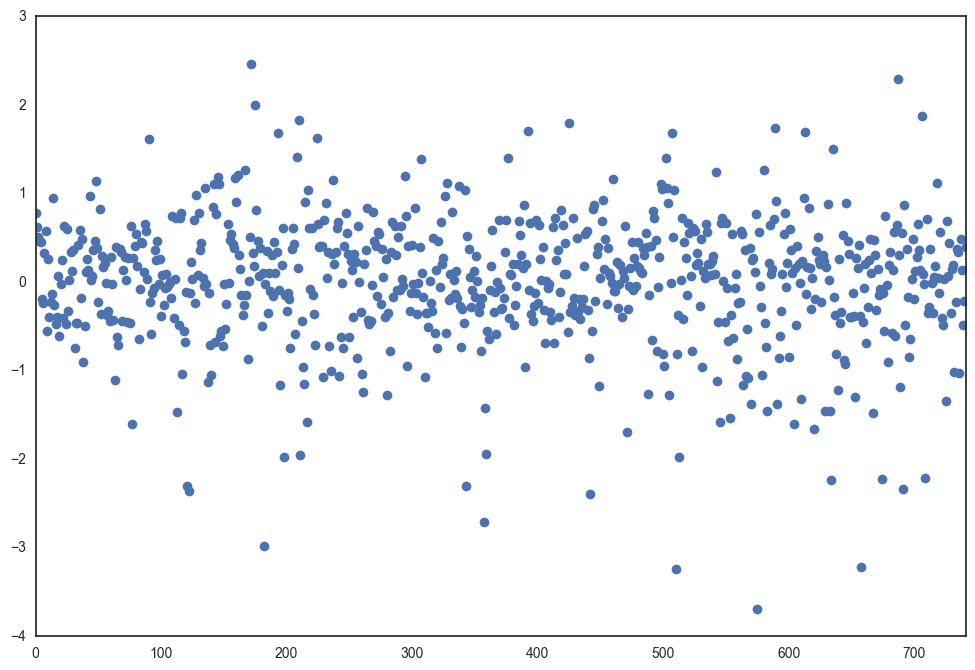

In [58]:
fit.resid.plot(style='o', figsize=(12,8));

### _Model 2: Keep features with P(t)<0.5_

In [100]:
model2 = books[['b_txt_rev_count', 'a_avg_rating', 'a_works_count_bx', 'a_ratings_count_bx', 'b_wks_on_list_bx', 'a_wks_on_list_bx', 'a_books_on_list_bx','b_repeat']]

In [101]:
lsm = sm.OLS(y,model2)
fit = lsm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           b_avg_rating   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     77.73
Date:                Sun, 05 Feb 2017   Prob (F-statistic):           1.26e-92
Time:                        18:59:09   Log-Likelihood:                -825.18
No. Observations:                 742   AIC:                             1666.
Df Residuals:                     734   BIC:                             1703.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
b_txt_rev_count        0.1346      0.036      3.789      0.000         0.065     0.204
a_avg_rating           0.6561      0.029     22.708      0.000         0.599     0.713
a_works_count_bx       0.1223      0.047      2.628      0.009         0.031     0.214
a_ratings_count_bx    -0.2698      0.055     -4.937      0.000        -0.377    -0.163
b_wks_on_list_bx       0.2030      0.053      3.842      0.000         0.099     0.307
a_wks_on_list_bx      -0.3735      0.072     -5.215      0.000        -0.514    -0.233
a_books_on_list_bx     0.3978      0.080      4.989      0.000         0.241     0.554
b_repeat              -0.0365      0.043     -0.843      0.400        -0.121     0.048
==============================================================================
Omnibus:                      136.979   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              381.059
Skew:                          -0.923   Prob(JB):                     1.80e-83
Kurtosis:                       5.986   Cond. No.                         7.10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

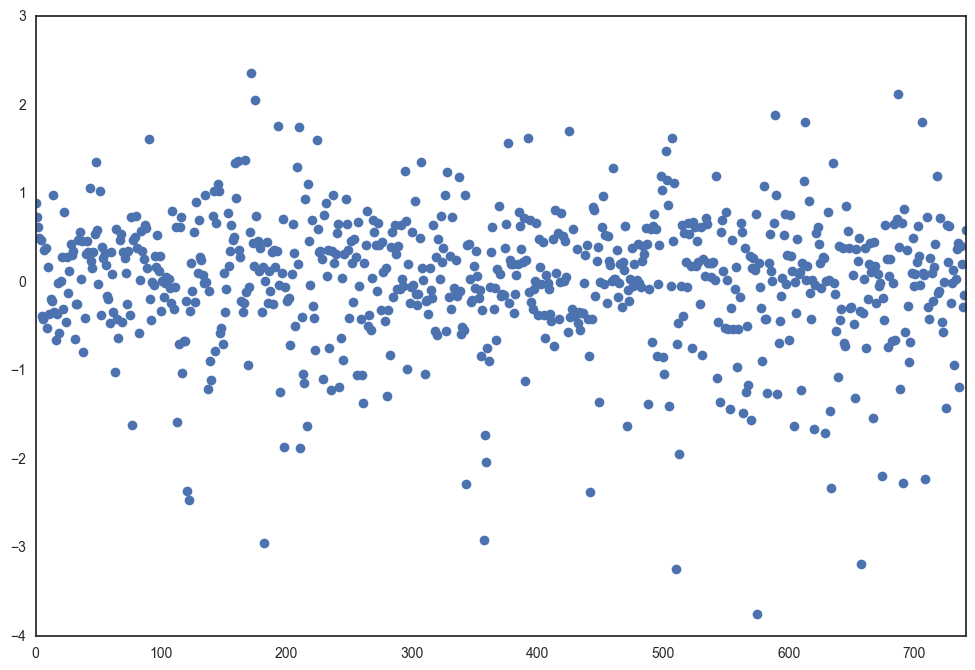

In [102]:
fit.resid.plot(style='o', figsize=(12,8));

### _Model 3: only author rating_

In [103]:
model3 = books['a_avg_rating']

In [104]:
lsm = sm.OLS(y,model3)
fit = lsm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           b_avg_rating   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     535.5
Date:                Sun, 05 Feb 2017   Prob (F-statistic):           1.39e-89
Time:                        18:59:26   Log-Likelihood:                -851.08
No. Observations:                 742   AIC:                             1704.
Df Residuals:                     741   BIC:                             1709.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
a_avg_rating     0.6477      0.028     23.140      0.000         0.593     0.703
==============================================================================
Omnibus:                      179.358   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              583.354
Skew:                          -1.144   Prob(JB):                    2.12e-127
Kurtosis:                       6.693   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

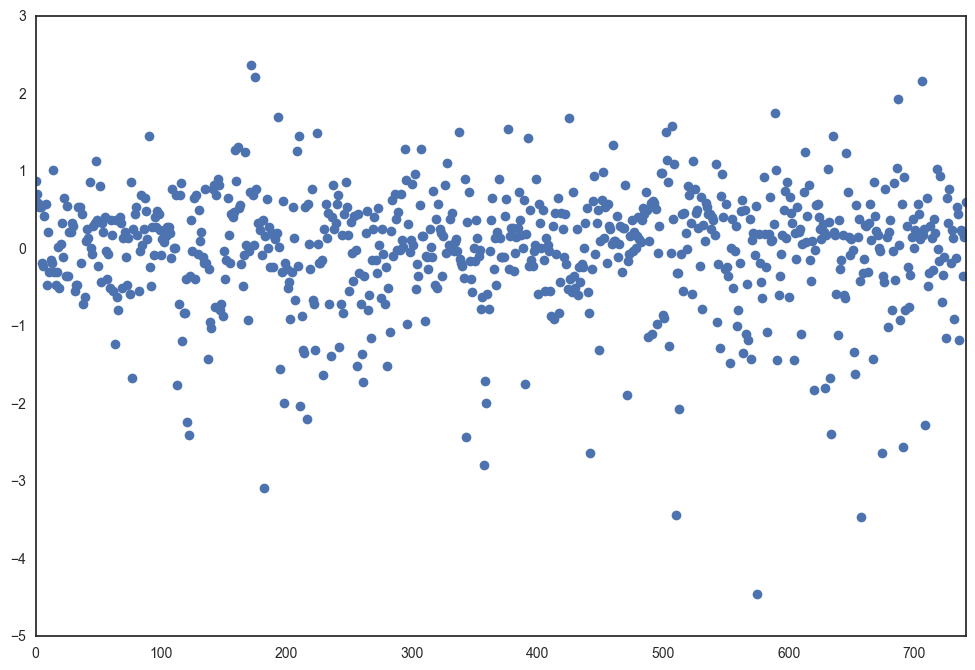

In [105]:
fit.resid.plot(style='o', figsize=(12,8));

### Cross validation of Model 2

In [106]:
# 10-fold cross-validation
reg = LinearRegression()
scores = cross_val_score(reg, model2, y, cv=10, scoring='neg_mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print np.sqrt(-scores.mean())

0.743427634189


In [107]:
def calc_avg_RMSE(model, X, y):
    scores = cross_val_score(model, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
    return np.sqrt(-scores.mean())

In [108]:
def find_best_model(X_scaled, y):
    '''
    model_type: LR, Lasso, Ridge, EN
    '''
    
    avg_RMSEs = {}
    
    #linear
    #model_LR = LinearRegression()
    
    
    #lasso
    model_LassoCV = LassoCV(cv=5, normalize=False)
    model_LassoCV.fit(X_scaled, y)
    model_Lasso = Lasso(alpha=model_LassoCV.alpha_)
    avg_RMSEs['lasso'] = calc_avg_RMSE(model_Lasso, X_scaled, y)
    
    #ridge
    model_RidgeCV = RidgeCV(cv=5, normalize=False)
    model_RidgeCV.fit(X_scaled, y)
    model_Ridge = Ridge(alpha=model_RidgeCV.alpha_)
    avg_RMSEs['ridge'] = calc_avg_RMSE(model_Ridge, X_scaled, y)
    
    #elasticnet
    model_ElasticCV = ElasticNetCV(cv=5, normalize=False)
    model_ElasticCV.fit(X_scaled, y)
    model_Elastic = ElasticNet(alpha=model_ElasticCV.alpha_)
    avg_RMSEs['elasticnet'] = calc_avg_RMSE(model_Elastic, X_scaled, y)
    
    models = {'lasso': model_Lasso,
             'ridge': model_Ridge,
             'elasticnet': model_Elastic}
    
    best_model_name =  min(avg_RMSEs.iteritems(), key=operator.itemgetter(1))[0]
    
    print avg_RMSEs
    
    #print 'best model: ', best_model_name
    #print 'avg RMSE: ', avg_RMSEs[best_model_name]
    #print 'coefficients: ', model_Elastic.get_params()

In [109]:
find_best_model(model2, y)

{'elasticnet': 0.7433759767788195, 'ridge': 0.74405972499214457, 'lasso': 0.74340087335944038}
